## Cross-Impact Analysis of Order Flow Imbalance (OFI)

#### Preprocess Data

In [1]:
from scripts.data_fetching import fetch_data, preprocess_data
import pandas as pd

symbols = ["AAPL", "TSLA", "AMGN", "XOM", "JPM"]
dataframes = []
for symbol in symbols: #for streaming size purpose
    df = fetch_data(symbol, "your api key")
    dataframes.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
df_cleaned = preprocess_data(combined_df)
print(df_cleaned.head())

Fetched data for AAPL: 2024-11-04 09:00:00.038685808+00:00 to 2024-11-08 23:56:20.939446039+00:00
Fetched data for TSLA: 2024-11-04 09:00:00.020895709+00:00 to 2024-11-08 23:59:59.925640311+00:00
Fetched data for AMGN: 2024-11-04 09:00:00.115479812+00:00 to 2024-11-08 23:59:19.081737867+00:00
Fetched data for XOM: 2024-11-04 09:00:00.049473982+00:00 to 2024-11-08 23:56:11.566208643+00:00
Fetched data for JPM: 2024-11-04 09:00:00.036223671+00:00 to 2024-11-08 23:59:53.811523573+00:00
                                    ts_event  rtype  publisher_id  \
10350393 2024-11-04 09:00:01.203124362+00:00     10             2   
10350394 2024-11-04 09:00:01.203141377+00:00     10             2   
10350441 2024-11-04 09:00:01.520473424+00:00     10             2   
10350448 2024-11-04 09:00:01.680303338+00:00     10             2   
10350515 2024-11-04 09:00:03.148641194+00:00     10             2   

          instrument_id action side  depth   price  size  flags  ...  \
10350393          16244  

In [2]:
print(df_cleaned[['bid_sz_00', 'ask_sz_00', 'bid_px_00', 'ask_px_00']].describe())


          bid_sz_00     ask_sz_00     bid_px_00     ask_px_00
count  2.989537e+07  2.989537e+07  2.989537e+07  2.989537e+07
mean   1.909388e+02  3.510708e+02  2.371921e+02  2.372396e+02
std    7.380779e+02  4.322722e+03  6.090739e+01  6.092941e+01
min    1.000000e+00  1.000000e+00  1.150000e+02  1.157400e+02
25%    3.500000e+01  4.000000e+01  2.227500e+02  2.227700e+02
50%    1.040000e+02  1.030000e+02  2.276400e+02  2.276600e+02
75%    2.250000e+02  2.250000e+02  2.880800e+02  2.881500e+02
max    9.800300e+04  3.625300e+05  3.286800e+02  3.287200e+02


#### Compute OFI Metrics

In [3]:
from scripts.calculate_ofi import calculate_ofi

# Calculer les OFI multi-niveaux
try:
    ofi_df = calculate_ofi(df_cleaned)
    ofi_df = ofi_df.iloc[1:]
    print(ofi_df.head())
except KeyError as e:
    print(f"Erreur : {e}")

grouped = ofi_df.groupby('symbol')[[f'nOFI_{level}' for level in range(5)]].mean()
print(grouped.head())

                                    ts_event  rtype  publisher_id  \
10350394 2024-11-04 09:00:01.203141377+00:00     10             2   
10350441 2024-11-04 09:00:01.520473424+00:00     10             2   
10350448 2024-11-04 09:00:01.680303338+00:00     10             2   
10350515 2024-11-04 09:00:03.148641194+00:00     10             2   
10350516 2024-11-04 09:00:03.292810385+00:00     10             2   

          instrument_id action side  depth   price  size  flags  ...  OFI_0  \
10350394          16244      A    B      2  246.95    76    130  ...    0.0   
10350441          16244      A    B      3  245.70  1000    130  ...  120.0   
10350448          16244      A    B      3  245.80  1000    130  ...   50.0   
10350515          16244      A    B      5  213.57     5    130  ...  300.0   
10350516          16244      A    B      6  213.55    20    130  ...    0.0   

           OFI_1   OFI_2   OFI_3   OFI_4    nOFI_0    nOFI_1    nOFI_2  \
10350394     0.0    76.0     0.0    

In [25]:
nofi = ofi_df[['nOFI_0', 'nOFI_1', 'nOFI_2', 'nOFI_3', 'nOFI_4']]
print(nofi.describe())

             nOFI_0        nOFI_1        nOFI_2        nOFI_3        nOFI_4
count  2.989536e+07  2.989536e+07  2.989536e+07  2.989536e+07  2.989536e+07
mean   5.272925e-02  1.053048e-02 -1.804156e-02 -2.811396e-02 -2.255630e-02
std    1.305299e+00  1.366499e+00  1.452743e+00  1.547255e+00  1.627236e+00
min   -2.472043e+02 -1.132844e+02 -1.212996e+02 -7.819549e+01 -8.683068e+01
25%   -1.082707e-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
75%    1.015228e-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
max    6.394471e+02  8.789088e+01  6.864989e+01  1.357466e+02  1.829571e+02


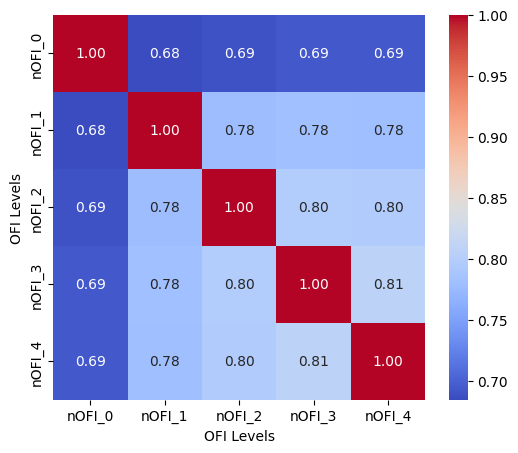

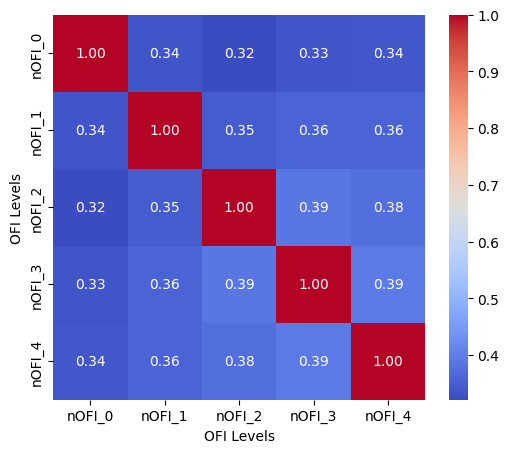

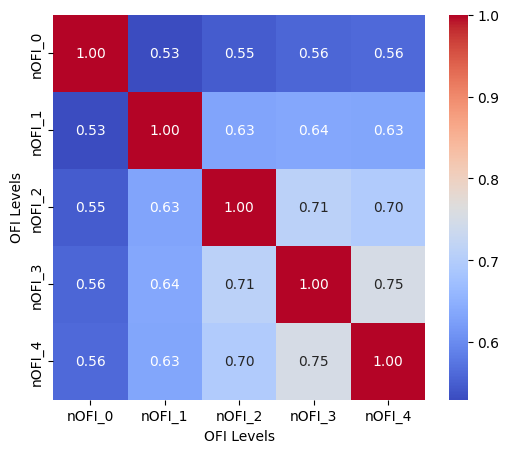

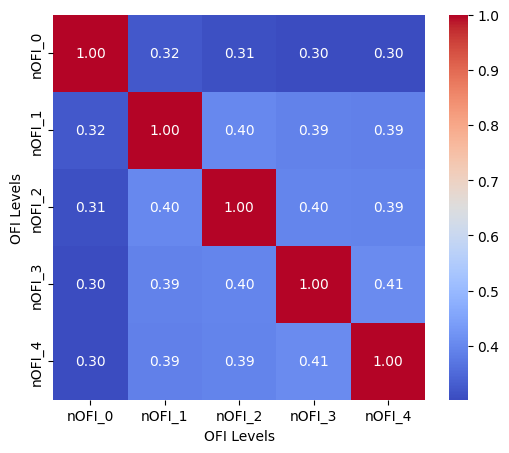

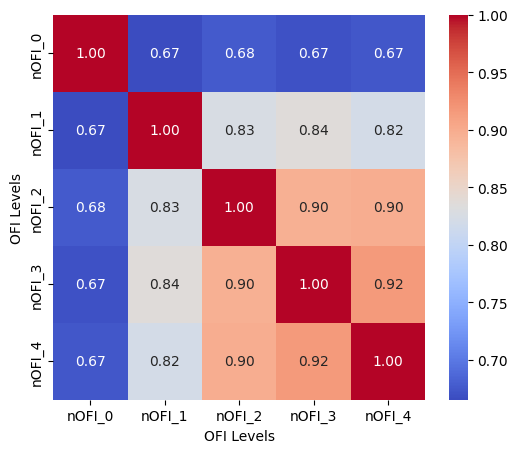

In [4]:
from scripts.viz import plot_correlation_matrices_by_stock
plot_correlation_matrices_by_stock(ofi_df)

PCA

In [23]:
from scripts.pca import integrate_ofi_with_pca

ofi_df['Integrated_OFI'] = integrate_ofi_with_pca(ofi_df)
full_data = ofi_df
print(full_data.head())

target_stocks = full_data['symbol'].unique()

Variance expliquée par la première composante principale : 0.6502
                                    ts_event  rtype  publisher_id  \
10350394 2024-11-04 09:00:01.203141377+00:00     10             2   
10350441 2024-11-04 09:00:01.520473424+00:00     10             2   
10350448 2024-11-04 09:00:01.680303338+00:00     10             2   
10350515 2024-11-04 09:00:03.148641194+00:00     10             2   
10350516 2024-11-04 09:00:03.292810385+00:00     10             2   

          instrument_id action side  depth   price  size  flags  ...   OFI_4  \
10350394          16244      A    B      2  246.95    76    130  ...     0.0   
10350441          16244      A    B      3  245.70  1000    130  ... -1401.0   
10350448          16244      A    B      3  245.80  1000    130  ...  1000.0   
10350515          16244      A    B      5  213.57     5    130  ...    35.0   
10350516          16244      A    B      6  213.55    20    130  ...     0.0   

            nOFI_0    nOFI_1    nOFI_2

#### Analyze Cross-Impact:

PI^1 model

In [6]:
multi_ofi_df = ofi_df.drop(columns=['Integrated_OFI'])  # Supprimer 'symbol' de ofi_df
multi_level_data = multi_ofi_df
print(multi_level_data.head())

                                    ts_event  rtype  publisher_id  \
10350394 2024-11-04 09:00:01.203141377+00:00     10             2   
10350441 2024-11-04 09:00:01.520473424+00:00     10             2   
10350448 2024-11-04 09:00:01.680303338+00:00     10             2   
10350515 2024-11-04 09:00:03.148641194+00:00     10             2   
10350516 2024-11-04 09:00:03.292810385+00:00     10             2   

          instrument_id action side  depth   price  size  flags  ...  OFI_0  \
10350394          16244      A    B      2  246.95    76    130  ...    0.0   
10350441          16244      A    B      3  245.70  1000    130  ...  120.0   
10350448          16244      A    B      3  245.80  1000    130  ...   50.0   
10350515          16244      A    B      5  213.57     5    130  ...  300.0   
10350516          16244      A    B      6  213.55    20    130  ...    0.0   

           OFI_1   OFI_2   OFI_3   OFI_4    nOFI_0    nOFI_1    nOFI_2  \
10350394     0.0    76.0     0.0    

In [7]:
from scripts.cross_impact_analysis import calculate_minute_price_changes_with_filters
multi_level_data = calculate_minute_price_changes_with_filters(multi_level_data, integrated=False).dropna()
print(multi_level_data.head())

  symbol                    minute  mid_price      nOFI_0     nOFI_1  \
1   AAPL 2024-11-04 10:01:00+00:00    221.840 -109.372669 -11.393006   
2   AAPL 2024-11-04 10:02:00+00:00    221.815 -114.108520 -21.423670   
3   AAPL 2024-11-04 10:03:00+00:00    221.850 -105.250601 -21.049182   
4   AAPL 2024-11-04 10:04:00+00:00    222.095 -110.953379 -48.921490   
5   AAPL 2024-11-04 10:05:00+00:00    222.075  -89.392808 -57.374396   

       nOFI_2     nOFI_3     nOFI_4  price_change  
1   -6.976695  -5.392167  -8.126284      0.000113  
2  -16.531614 -22.308406 -15.782514     -0.000113  
3  -18.874894 -24.959395  -9.427080      0.000158  
4 -113.309242 -25.174043   9.007906      0.001104  
5  -70.089433 -53.180712 -27.414251     -0.000090  


/Users/benjaminemily/Developer/Projects/OFI_Cross-Impact_Analysis(Blockhouse_Intership)/scripts/cross_impact_analysis.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [8]:
from scripts.cross_impact_analysis import analyze_impact_with_multi_level_ofi
import numpy as np

multi_level_self_impact_results = analyze_impact_with_multi_level_ofi(multi_level_data, cross_impact=False)
for symbol, metrics in multi_level_self_impact_results.items():
     print(f"{symbol}: IS R^2 = {metrics['IS R^2']:.4f}")

is_r2_values = [metrics['IS R^2'] for symbol, metrics in multi_level_self_impact_results.items()]
mean_is_r2 = np.mean(is_r2_values)
std_is_r2 = np.std(is_r2_values)

print(f"Moyenne des IS R² : {mean_is_r2:.4f}")
print(f"Écart-type des IS R² : {std_is_r2:.4f}")

AAPL: IS R^2 = 0.0333
AMGN: IS R^2 = 0.0156
JPM: IS R^2 = 0.0030
TSLA: IS R^2 = 0.0023
XOM: IS R^2 = 0.0074
Moyenne des IS R² : 0.0123
Écart-type des IS R² : 0.0115


CI^1 model

In [9]:
from scripts.cross_impact_analysis import analyze_impact_with_multi_level_ofi

multi_level_cross_impact_results = analyze_impact_with_multi_level_ofi(multi_level_data, cross_impact=True)
for symbol, metrics in multi_level_cross_impact_results.items():
     print(f"{symbol}: IS R^2 = {metrics['IS R^2']:.4f}")

is_r2_values = [metrics['IS R^2'] for symbol, metrics in multi_level_cross_impact_results.items()]
mean_is_r2 = np.mean(is_r2_values)
std_is_r2 = np.std(is_r2_values)

print(f"Moyenne des IS R² : {mean_is_r2:.4f}")
print(f"Écart-type des IS R² : {std_is_r2:.4f}")

AAPL: IS R^2 = 0.1695
AMGN: IS R^2 = 0.1159
JPM: IS R^2 = 0.0176
TSLA: IS R^2 = 0.0678
XOM: IS R^2 = 0.0346
Moyenne des IS R² : 0.0811
Écart-type des IS R² : 0.0555


PI^I model

In [24]:
from scripts.cross_impact_analysis import calculate_minute_price_changes_with_filters

# Analysez l'impact contemporain
full_data = calculate_minute_price_changes_with_filters(full_data).dropna()
print(full_data)
print(full_data.size)

     symbol                    minute  mid_price  Integrated_OFI  price_change
1      AAPL 2024-11-04 10:01:00+00:00    221.840      -18.896847      0.000113
2      AAPL 2024-11-04 10:02:00+00:00    221.815      -25.616247     -0.000113
3      AAPL 2024-11-04 10:03:00+00:00    221.850      -24.255124      0.000158
4      AAPL 2024-11-04 10:04:00+00:00    222.095      -40.199032      0.001104
5      AAPL 2024-11-04 10:05:00+00:00    222.075      -40.980319     -0.000090
...     ...                       ...        ...             ...           ...
7628    XOM 2024-11-08 15:25:00+00:00    120.255    -1688.833902     -0.000374
7629    XOM 2024-11-08 15:26:00+00:00    120.200    -1875.949221     -0.000457
7630    XOM 2024-11-08 15:27:00+00:00    120.180    -1662.352556     -0.000166
7631    XOM 2024-11-08 15:28:00+00:00    120.225    -1288.179307      0.000374
7632    XOM 2024-11-08 15:29:00+00:00    120.120    -1928.743896     -0.000874

[7628 rows x 5 columns]
38140


/Users/benjaminemily/Developer/Projects/OFI_Cross-Impact_Analysis(Blockhouse_Intership)/scripts/cross_impact_analysis.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [11]:
from scripts.cross_impact_analysis import analyze_impact_with_integrated_ofi

integrated_self_impact_results = analyze_impact_with_integrated_ofi(full_data, cross_impact=False)
for symbol, metrics in integrated_self_impact_results.items():
     print(f"{symbol}: IS R^2 = {metrics['IS R^2']:.4f}")

is_r2_values = [metrics['IS R^2'] for symbol, metrics in integrated_self_impact_results.items()]
mean_is_r2 = np.mean(is_r2_values)
std_is_r2 = np.std(is_r2_values)

print(f"Moyenne des IS R² : {mean_is_r2:.4f}")
print(f"Écart-type des IS R² : {std_is_r2:.4f}")

AAPL: IS R^2 = 0.0010
AMGN: IS R^2 = 0.0017
JPM: IS R^2 = 0.0011
TSLA: IS R^2 = 0.0006
XOM: IS R^2 = 0.0003
Moyenne des IS R² : 0.0009
Écart-type des IS R² : 0.0005


CI^I model

AAPL: IS R^2 = 0.1315
AMGN: IS R^2 = 0.0160
JPM: IS R^2 = 0.0069
TSLA: IS R^2 = 0.0580
XOM: IS R^2 = 0.0041
Moyenne des IS R² : 0.0433
Écart-type des IS R² : 0.0482


/Users/benjaminemily/Developer/Projects/OFI_Cross-Impact_Analysis(Blockhouse_Intership)/scripts/viz.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  coefficients = coefficients.fillna(0).infer_objects(copy=False)


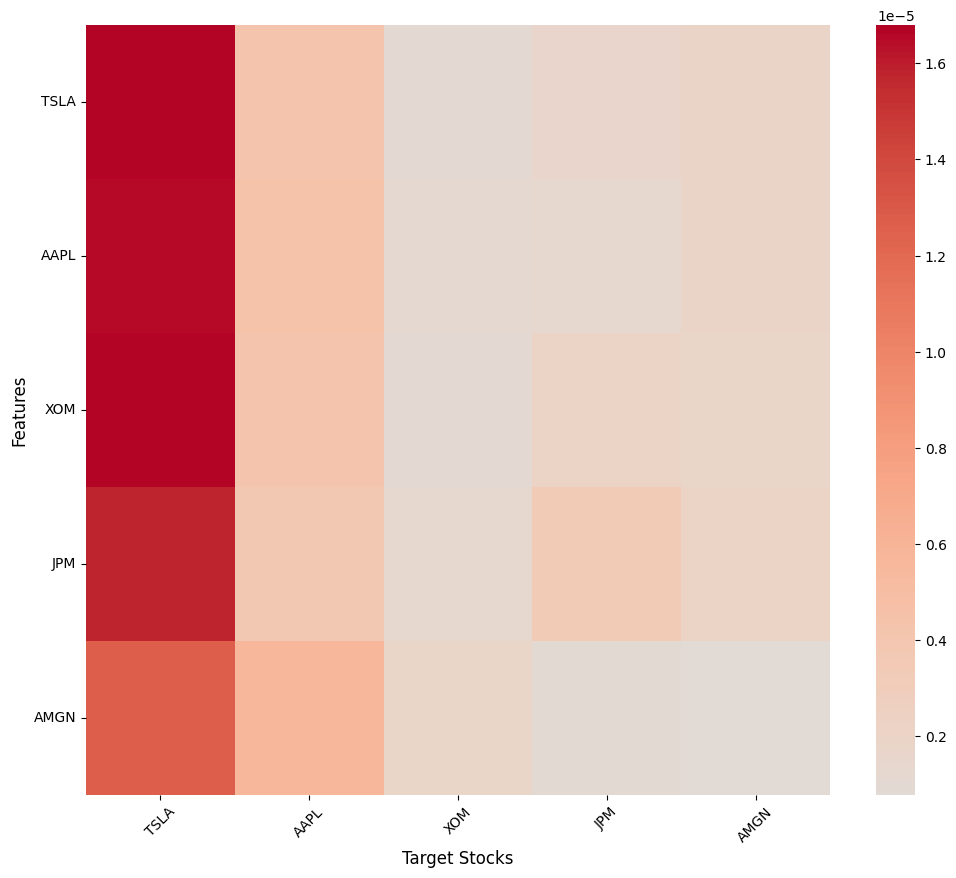

In [12]:
from scripts.cross_impact_analysis import analyze_impact_with_integrated_ofi
from scripts.viz import plot_heatmap_coefficients


integrated_cross_impact_results = analyze_impact_with_integrated_ofi(full_data)
for symbol, metrics in integrated_cross_impact_results.items():
     print(f"{symbol}: IS R^2 = {metrics['IS R^2']:.4f}")

is_r2_values = [metrics['IS R^2'] for symbol, metrics in integrated_cross_impact_results.items()]
mean_is_r2 = np.mean(is_r2_values)
std_is_r2 = np.std(is_r2_values)

print(f"Moyenne des IS R² : {mean_is_r2:.4f}")
print(f"Écart-type des IS R² : {std_is_r2:.4f}")

#Plot heatmap of regression coefficients
plot_heatmap_coefficients(integrated_cross_impact_results, target_stocks)

#### Predictive model

FPI^1 model

In [13]:
from scripts.cross_impact_analysis import analyze_impact_with_multi_level_ofi

multi_level_cross_impact_results = analyze_impact_with_multi_level_ofi(multi_level_data, lagged=True, lag_steps=30, cross_impact=False)
for symbol, metrics in multi_level_cross_impact_results.items():
     print(f"{symbol}: OOS R^2 = {metrics['OOS R^2']:.4f}")

os_r2_values = [metrics['OOS R^2'] for symbol, metrics in multi_level_cross_impact_results.items()]
mean_os_r2 = np.mean(os_r2_values)
std_os_r2 = np.std(os_r2_values)

print(f"Moyenne des IS R² : {mean_os_r2:.4f}")
print(f"Écart-type des IS R² : {std_os_r2:.4f}")

AAPL: OOS R^2 = -0.2610
AMGN: OOS R^2 = -0.4584
JPM: OOS R^2 = -2.5997
TSLA: OOS R^2 = -1.6044
XOM: OOS R^2 = -2.2088
Moyenne des IS R² : -1.4265
Écart-type des IS R² : 0.9290


FCI^1 model

In [14]:
from scripts.cross_impact_analysis import analyze_impact_with_multi_level_ofi

multi_level_cross_impact_results = analyze_impact_with_multi_level_ofi(multi_level_data, lagged=True, lag_steps=30, cross_impact=True)
for symbol, metrics in multi_level_cross_impact_results.items():
     print(f"{symbol}: OOS R^2 = {metrics['OOS R^2']:.4f}")

os_r2_values = [metrics['OOS R^2'] for symbol, metrics in multi_level_cross_impact_results.items()]
mean_os_r2 = np.mean(os_r2_values)
std_os_r2 = np.std(os_r2_values)

print(f"Moyenne des IS R² : {mean_os_r2:.4f}")
print(f"Écart-type des IS R² : {std_os_r2:.4f}")

AAPL: OOS R^2 = -11.0285
AMGN: OOS R^2 = -31.7492
JPM: OOS R^2 = -19.6570
TSLA: OOS R^2 = -34.1381
XOM: OOS R^2 = -30.1536
Moyenne des IS R² : -25.3453
Écart-type des IS R² : 8.7037


FPI^I model

In [26]:
from scripts.cross_impact_analysis import analyze_impact_with_integrated_ofi


lagged_self_impact_results = analyze_impact_with_integrated_ofi(full_data, lagged=True, lag_steps=30, cross_impact=False)
for symbol, metrics in lagged_self_impact_results.items():
     print(f"{symbol}: OOS R^2 = {metrics['OOS R^2']:.4f}")

os_r2_values = [metrics['OOS R^2'] for symbol, metrics in lagged_self_impact_results.items()]
mean_os_r2 = np.mean(os_r2_values)
std_os_r2 = np.std(os_r2_values)

print(f"Moyenne des OS R² : {mean_os_r2:.4f}")
print(f"Écart-type des 0S R² : {std_os_r2:.4f}")

AAPL: OOS R^2 = -0.0922
AMGN: OOS R^2 = -0.1415
JPM: OOS R^2 = -0.4122
TSLA: OOS R^2 = -0.2163
XOM: OOS R^2 = -0.1970
Moyenne des OS R² : -0.2119
Écart-type des 0S R² : 0.1092


FCI^I model

In [27]:
from scripts.cross_impact_analysis import analyze_impact_with_integrated_ofi
from scripts.viz import plot_heatmap_coefficients

lagged_cross_impact_results = analyze_impact_with_integrated_ofi(full_data, lagged=True, lag_steps=30)
for symbol, metrics in lagged_cross_impact_results.items():
     print(f"{symbol}: OOS R^2 = {metrics['OOS R^2']:.4f}")

os_r2_values = [metrics['OOS R^2'] for symbol, metrics in lagged_cross_impact_results.items()]
mean_os_r2 = np.mean(os_r2_values)
std_os_r2 = np.std(os_r2_values)

print(f"Moyenne des OS R² : {mean_os_r2:.4f}")
print(f"Écart-type des OS R² : {std_os_r2:.4f}")

AAPL: OOS R^2 = -0.1918
AMGN: OOS R^2 = -0.2882
JPM: OOS R^2 = -1.1363
TSLA: OOS R^2 = -1.8736
XOM: OOS R^2 = -1.7821
Moyenne des IS R² : -1.0544
Écart-type des IS R² : 0.7125


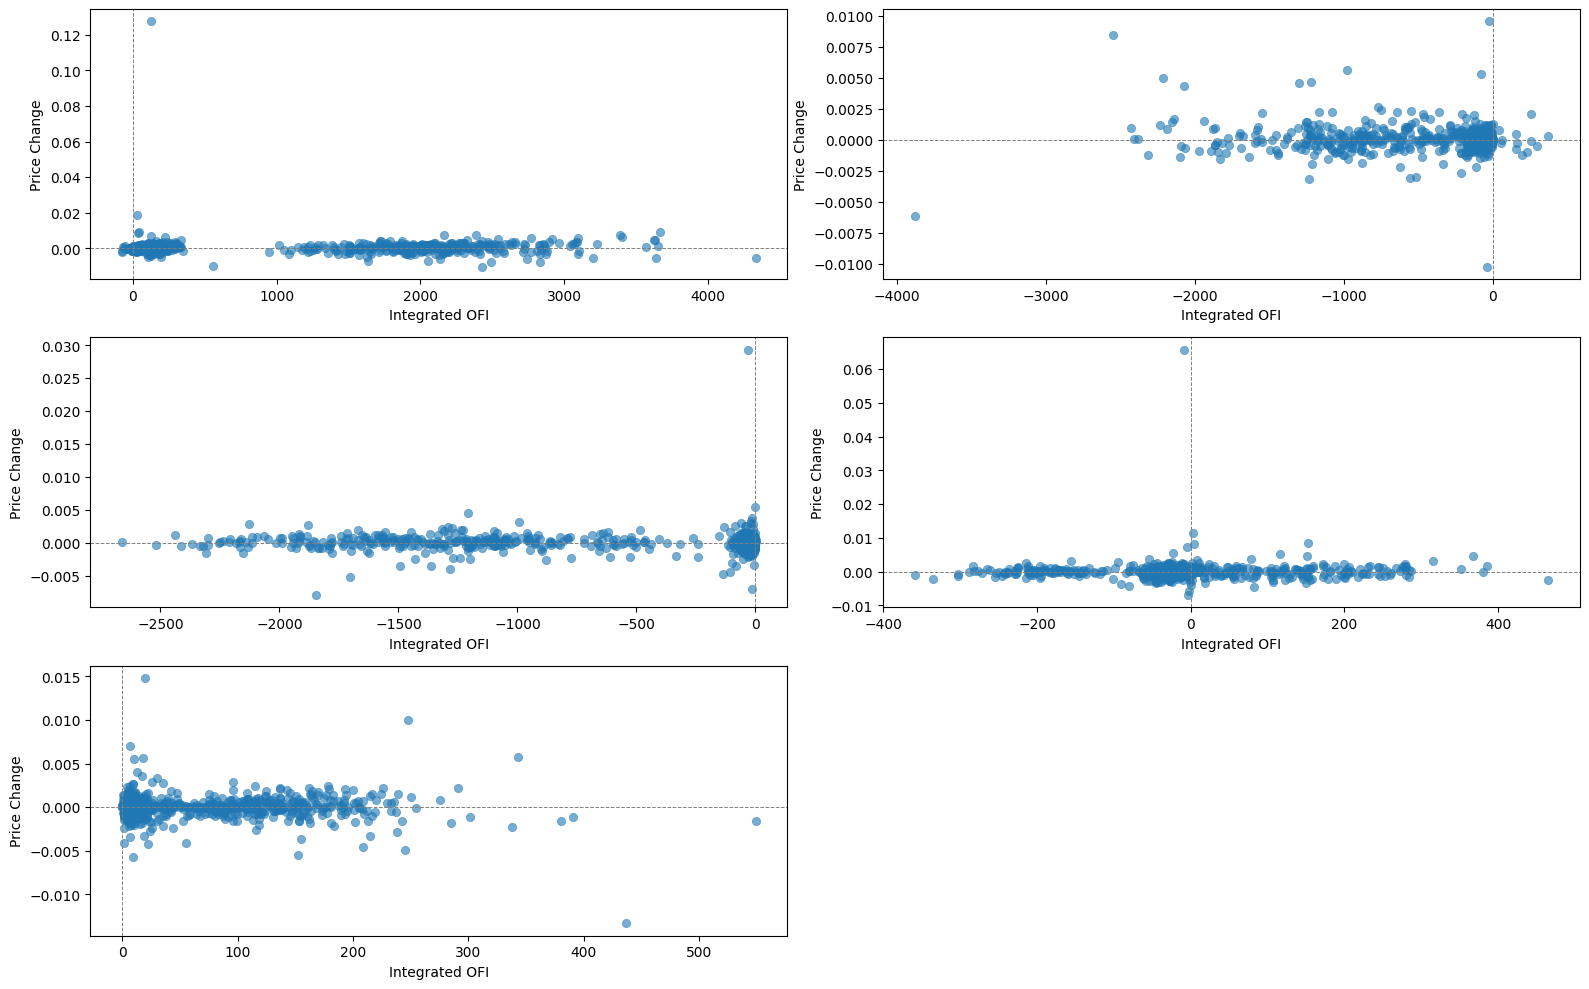

In [17]:
from scripts.viz import plot_scatter_ofi_vs_price_change

#Plot scatter plots of OFI vs price change for each target stock
plot_scatter_ofi_vs_price_change(full_data, target_stocks)  #TSLA JPM AAPL XOM AMGN

#### Compare Self-Impact vs. Cross-Impact

Non-lagged

{'TSLA': {'self_r2': 0.0006330967525522979, 'cross_r2': 0.057986461646514775}, 'AAPL': {'self_r2': 0.0009536687940719935, 'cross_r2': 0.13144210040835547}, 'XOM': {'self_r2': 0.00030391822004793845, 'cross_r2': 0.004125698788166154}, 'JPM': {'self_r2': 0.0011490762922909958, 'cross_r2': 0.006860551367314338}, 'AMGN': {'self_r2': 0.001694169928125988, 'cross_r2': 0.016059222235054293}}


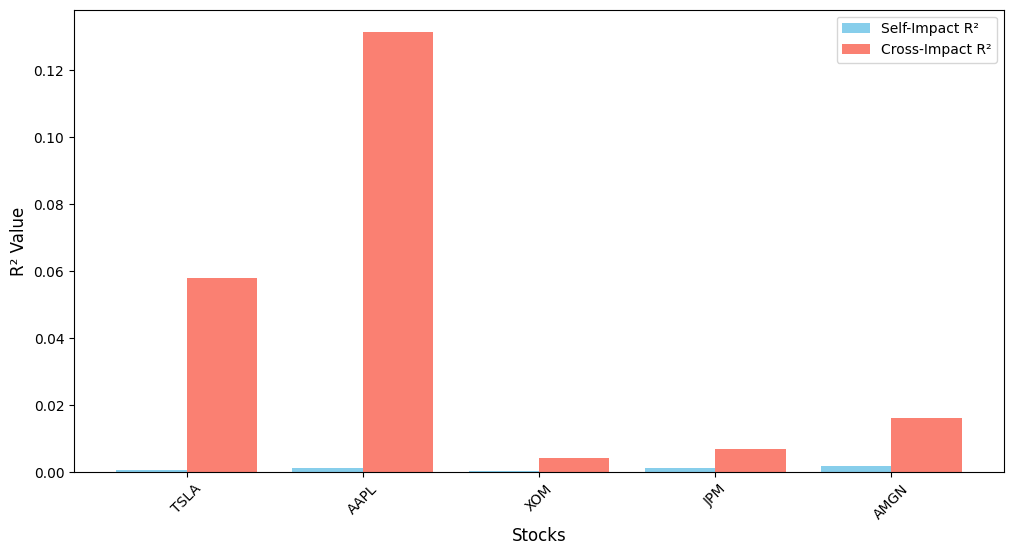

In [18]:
from scripts.comparison import compare_self_vs_cross_impact
from scripts.viz import plot_self_vs_cross_comparison

comparison_results = compare_self_vs_cross_impact(full_data, target_stocks, lagged=False)
print(comparison_results)
plot_self_vs_cross_comparison(comparison_results)

Lagged

{'TSLA': {'self_r2': -0.21619842089278762, 'cross_r2': -1.8734189652663584}, 'AAPL': {'self_r2': -0.09225922398501218, 'cross_r2': -0.19184205059485526}, 'XOM': {'self_r2': -0.1971361233900013, 'cross_r2': -1.7823623518154812}, 'JPM': {'self_r2': -0.41209184745555616, 'cross_r2': -1.1364397460442222}, 'AMGN': {'self_r2': -0.1416153927699242, 'cross_r2': -0.2878657252463388}}


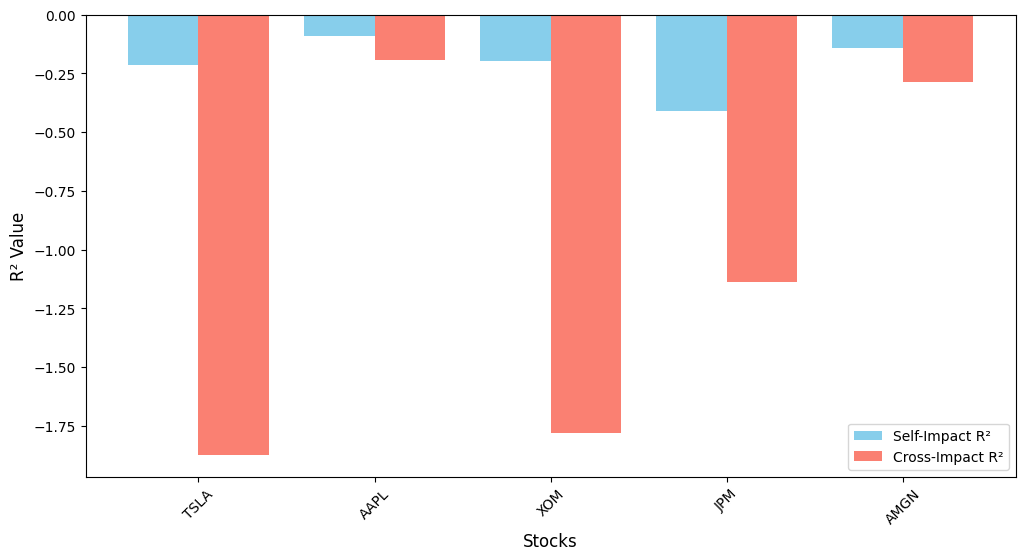

In [19]:
from scripts.comparison import compare_self_vs_cross_impact
from scripts.viz import plot_self_vs_cross_comparison

comparison_results = compare_self_vs_cross_impact(full_data, target_stocks, lagged=True, lag_steps=30)
print(comparison_results)
plot_self_vs_cross_comparison(comparison_results)

### Bonus

         AAPL_Lag1     AMGN_Lag1      JPM_Lag1     TSLA_Lag1      XOM_Lag1  \
AAPL  3.314675e-07  5.816547e-07  2.181415e-06  5.926600e-07  5.531702e-07   
AMGN  5.471408e-07 -1.873919e-06  1.076971e-07  1.030736e-06  1.845244e-06   
JPM   1.279072e-06 -9.527998e-07  1.765523e-06  2.491593e-06  3.851122e-06   
TSLA  2.599903e-06 -7.154964e-06  2.458469e-07  4.758245e-06  7.328124e-06   
XOM  -6.293090e-07 -3.959130e-06 -1.671439e-06  3.223740e-07  2.917221e-07   

         AAPL_Lag2     AMGN_Lag2      JPM_Lag2     TSLA_Lag2      XOM_Lag2  \
AAPL -1.202404e-06 -1.116582e-06  4.546210e-08 -9.826871e-07 -1.067055e-06   
AMGN  1.238272e-06  1.977557e-06 -2.645968e-07  1.340790e-06  1.074931e-06   
JPM   1.476095e-06 -2.880139e-06 -8.240869e-07  4.441584e-07 -8.578548e-07   
TSLA -1.839810e-06 -2.795749e-07 -2.744487e-06 -2.238571e-06 -5.368789e-06   
XOM  -2.633470e-07 -7.147526e-08 -7.462091e-07 -7.661902e-07 -8.825936e-07   

      ...    AAPL_Lag29    AMGN_Lag29     JPM_Lag29    TSLA_La

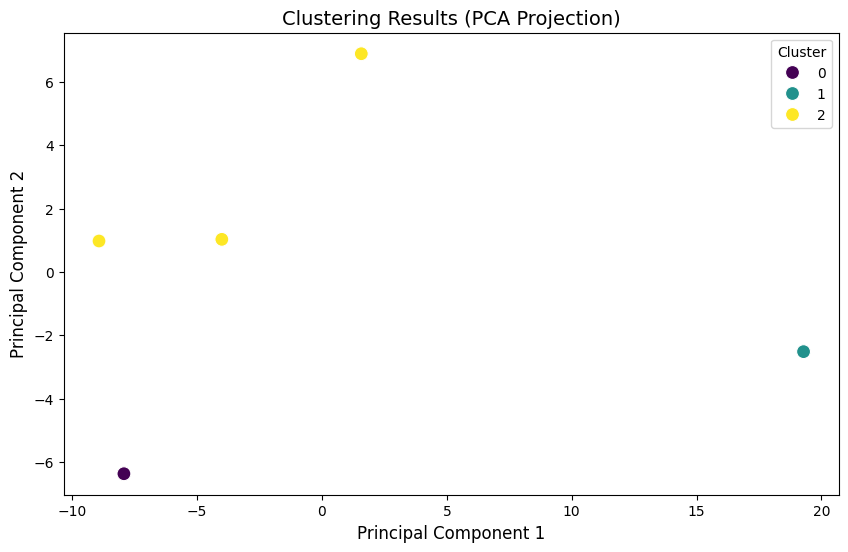

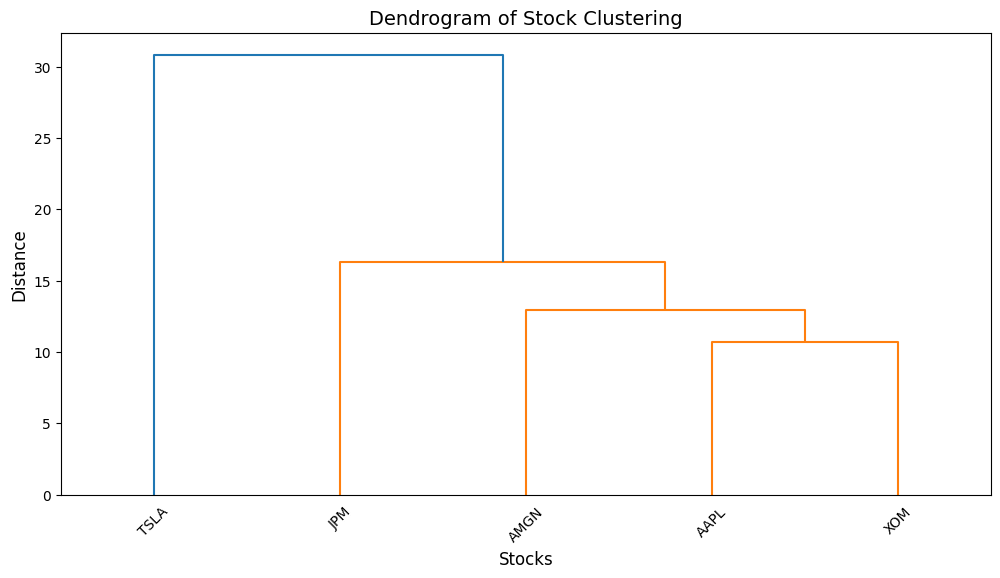

In [20]:
from scripts.bonus import prepare_clustering_data, perform_kmeans_clustering, plot_pca_clusters, perform_hierarchical_clustering,  plot_dendrogram

clustering_data = prepare_clustering_data(lagged_cross_impact_results)
print(clustering_data.head())

cluster_labels, kmeans = perform_kmeans_clustering(clustering_data, n_clusters=3)
plot_pca_clusters(clustering_data, cluster_labels)

linkage_matrix = perform_hierarchical_clustering(clustering_data)
plot_dendrogram(linkage_matrix, labels=clustering_data.index)

In [21]:
from scripts.bonus import analyze_cross_impact_with_xgboost
xgboost_results = analyze_cross_impact_with_xgboost(full_data, lagged=True, lag_steps=30)

# Afficher les résultats pour un symbole
for symbol, metrics in xgboost_results.items():
    print(f"{symbol}: OOS R^2 = {metrics['OOS R^2']:.4f}")

os_r2_values = [metrics['OOS R^2'] for symbol, metrics in xgboost_results.items()]
mean_os_r2 = np.mean(os_r2_values)
std_os_r2 = np.std(os_r2_values)

print(f"Moyenne des IS R² : {mean_os_r2:.4f}")
print(f"Écart-type des IS R² : {std_os_r2:.4f}")

AAPL: OOS R^2 = -1.8342
AMGN: OOS R^2 = -2.5488
JPM: OOS R^2 = -0.3660
TSLA: OOS R^2 = -0.6906
XOM: OOS R^2 = -0.0264
Moyenne des IS R² : -1.0932
Écart-type des IS R² : 0.9484
